# Batch integration and cell clustering

In [15]:
fig_folder='./PLOTS/'

In [1]:
#Function for gene ID - gene name conversion
convertGeneList <- function(x){
    #Read the list for the conversion
    conv.list<-read.csv('./data/conversion_geneID_genename_Xenopus_Laevis.csv')
    #Find the indices of my list in the conversion list
    indices<- which(conv.list[,'gene_id'] %in% x) 
    #Return the gene names and make them unique
    make.unique(as.character(conv.list[,'gene_name'][indices]))
}

Download the UMI count matrices from the Gene Expression Omnibus and store them in the "/data/" folder.

In [3]:
library(Seurat)
library(ggplot2)
library(cowplot)

SIGAH12.data<-read.table(file=paste0("./data/","SIGAH12_NT_raw.csv"),
                         row.names = 1,header=TRUE,sep=",")
rownames(SIGAH12.data) <- convertGeneList(rownames(SIGAH12.data))
print(head(rownames(SIGAH12.data)))
SIGAH12 <- CreateSeuratObject(counts = SIGAH12.data, project = "SIGAH12")
SIGAH12$stim <- "SIGAH12"
SIGAH12$isnt <- "NT"
SIGAH12 <- subset(SIGAH12, subset = nFeature_RNA > 0)
SIGAH12 <- NormalizeData(SIGAH12, verbose = FALSE)
SIGAH12 <- FindVariableFeatures(SIGAH12, selection.method = "vst", nfeatures = 2000)

SIGAH5.data<-read.table(file=paste0("./data/","SIGAH5_IVF_raw.csv"),
                        row.names = 1,header=TRUE,sep=",")
rownames(SIGAH5.data) <- convertGeneList(rownames(SIGAH5.data))
SIGAH5 <- CreateSeuratObject(counts = SIGAH5.data, project = "SIGAH5")
SIGAH5$stim <- "SIGAH5"
SIGAH5$isnt <- "IVF"
SIGAH5 <- subset(SIGAH5, subset = nFeature_RNA > 0)
SIGAH5 <- NormalizeData(SIGAH5, verbose = FALSE)
SIGAH5 <- FindVariableFeatures(SIGAH5, selection.method = "vst", nfeatures = 2000)

SIGAA2.data<-read.table(file=paste0("./data/","SIGAA2_IVF_raw.csv"),
                        row.names = 1,header=TRUE,sep=",")
rownames(SIGAA2.data) <- convertGeneList(rownames(SIGAA2.data))
SIGAA2 <- CreateSeuratObject(counts = SIGAA2.data, project = "SIGAA2")
SIGAA2$stim <- "SIGAA2"
SIGAA2$isnt <- "IVF"
SIGAA2 <- subset(SIGAA2, subset = nFeature_RNA > 0)
SIGAA2 <- NormalizeData(SIGAA2, verbose = FALSE)
SIGAA2 <- FindVariableFeatures(SIGAA2, selection.method = "vst", nfeatures = 2000)


SIGAB2.data<-read.table(file=paste0("./data/","SIGAB2_NT_raw.csv"),
                        row.names = 1,header=TRUE,sep=",")
rownames(SIGAB2.data) <- convertGeneList(rownames(SIGAB2.data))
SIGAB2 <- CreateSeuratObject(counts = SIGAB2.data, project = "SIGAB2")
SIGAB2$stim <- "SIGAB2"
SIGAB2$isnt <- "NT"
SIGAB2 <- subset(SIGAB2, subset = nFeature_RNA > 0)
SIGAB2 <- NormalizeData(SIGAB2, verbose = FALSE)
SIGAB2 <- FindVariableFeatures(SIGAB2, selection.method = "vst", nfeatures = 2000)


Markers <- read.delim("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Gene_lists/Markers.txt")
markerlist <- c(paste(Markers$Marker_genes,".L",sep = "")
                ,paste(Markers$Marker_genes,".S",sep = ""))

[1] "Xelaev18000001m.g" "Xelaev18000003m.g" "Xelaev18000004m.g"
[4] "Xelaev18000005m.g" "tm6sf2.1"          "Xelaev18000007m.g"


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


Perform batch integration

In [4]:
xenopus.anchors <- FindIntegrationAnchors(object.list = list(SIGAH5, SIGAA2, SIGAH12, SIGAB2),
                                          dims = 1:20, anchor.features = 2000)
xenopus.combined <- IntegrateData(anchorset = xenopus.anchors, dims = 1:20)
DefaultAssay(xenopus.combined) <- "integrated"
xenopus.combined <- ScaleData(xenopus.combined, verbose = FALSE)

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2277 anchors

Filtering anchors

	Retained 1822 anchors

Extracting within-dataset neighbors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2959 anchors

Filtering anchors

	Retained 2246 anchors

Extracting within-dataset neighbors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2185 anchors

Filtering anchors

	Retained 1373 anchors

Extracting within-dataset neighbors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2007 anchors

Filtering anchors

	Retained 1776 anchors

Extracting within-dataset neighbors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1713 anchors

Filtering anchors

	Retained 1552 anchors

Extracting within-dataset neighbors

Running CCA

Merging objects

Finding n

# Robustness analysis

In [ ]:
library(mcclust)

# nr of repeats for bootsraping
nrRepeats = 50
# percent of HVGs to retain
percent = 50
# nr of HVGs left
sampleSize <- round(length(rownames(xenopus.combined))*percent/100)
print(sampleSize)

# function to bootstrap
# indexVector is a vector with the indices of HVG
# percent defines how many genes will be left out. The default is 50 %
# nrRepeats defines how many times you want to repeat the sampling
myBootstrap <- function(indexVector){
        idxMatrix <- matrix(rep(NA, sampleSize*nrRepeats)
                            ,nrow = nrRepeats)
        for (i in 1:nrow(idxMatrix)){
                mySample <- sample(indexVector
                                   ,size = sampleSize)
                idxMatrix[i,] <- mySample
        }
        idxMatrix
}

# indices of all HVGs
HVGidx <- rownames(xenopus.combined)
bootstrapIdxMatrix <- myBootstrap(HVGidx)
# function to calculated clusters
calculateClusters <- function(geneIndices,nn,res){
    subset.xenopus.combined <- xenopus.combined[geneIndices]
    subset.xenopus.combined <- RunPCA(subset.xenopus.combined,features=geneIndices,
                                      npcs = 30, verbose = FALSE)
    subset.xenopus.combined <- FindNeighbors(subset.xenopus.combined,k.param=nn, 
    reduction = "pca", dims = 1:20)
    subset.xenopus.combined <- FindClusters(subset.xenopus.combined, resolution = res)
    as.vector(Idents(subset.xenopus.combined))
}



res.vec <- seq(0.1, 1.5, by = 0.1)
k.vec <- seq(10,40,by=5)
VarInfoVector <- matrix(rep(NA, nrRepeats))
VarInfoMatrix.mean <- matrix(rep(NA, length(k.vec)*length(res.vec)),nrow=length(k.vec),
                        ncol = length(res.vec))
VarInfoMatrix.var <- matrix(rep(NA, length(k.vec)*length(res.vec)),nrow=length(k.vec),
                        ncol = length(res.vec))

i<-1
for(k in k.vec){
    j<-1
    for(r in res.vec){
        tot.clust <- calculateClusters(HVGidx,k,r)
        for (l in 1:nrow(bootstrapIdxMatrix)){
            # take indices of HVGs from the bootstrapIdxMatrix of the i-th iteration
            indices <- bootstrapIdxMatrix[l,]
            # calculate the cluster statistics with these indices and deepSplit == r
            subsample.clust <- calculateClusters(indices,k,r)
            if(length(duplicated(indices)[duplicated(indices) == TRUE])>0){print(ERROR)}
            #Calculate the variation of information between the two clustering (whole dataset and subsampled data)
            VarInfoVector[l] <- vi.dist(tot.clust,subsample.clust)
        }
        VarInfoMatrix.mean[i,j]<- mean(VarInfoVector)
        VarInfoMatrix.var[i,j]<- var(VarInfoVector)
        j<-j+1
    }
    i<- i+1
}

Loading required package: lpSolve



[1] 1000


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 53342

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9585
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9585
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56060

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9583
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56963

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9579
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9579
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55835

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9588
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56890

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9582
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56906

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9573
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56644

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9587
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9581
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9579
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56949

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9597
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57101

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9577
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57089

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9593
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56706

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9572
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9586
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9581
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56733

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9585
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56386

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9577
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57273

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9571
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57515

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9574
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57048

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9572
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9576
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56817

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9583
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56543

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9586
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57323

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9576
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57846

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9566
Number of communities: 6
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56913

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9570
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56479

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9588
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56409

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9571
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56647

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9585
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9572
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57013

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9571
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56233

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9580
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57741

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9588
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56797

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9588
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57293

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9584
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56796

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9575
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9573
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56296

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9593
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56843

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9587
Number of communities: 6
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56996

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9590
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57532

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9588
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56709

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9570
Number of communities: 6
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56483

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9587
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56516

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9581
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56888

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9570
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56541

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9574
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56174

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9581
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56908

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9585
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57036

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9572
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 53342

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9308
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9302
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56060

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9305
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56963

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9304
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9291
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55835

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9311
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56890

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9293
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56906

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9298
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56644

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9316
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9300
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9309
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56949

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9315
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57101

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9287
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57089

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9310
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56706

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9297
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9303
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9309
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56733

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9297
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56386

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9302
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57273

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9300
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57515

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9298
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57048

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9280
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9299
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56817

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9302
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56543

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9318
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57323

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9296
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57846

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9293
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56913

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9286
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56479

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9296
Number of communities: 7
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56409

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9283
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56647

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9311
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9291
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57013

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9293
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56233

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9301
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57741

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9292
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56797

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9306
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57293

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9289
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56796

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9287
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9294
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56296

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9310
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56843

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9299
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56996

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9308
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57532

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9308
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56709

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9286
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56483

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9301
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56516

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9305
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56888

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9291
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56541

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9286
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56174

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9308
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56908

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9309
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57036

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9301
Number of communities: 8
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 53342

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9126
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9065
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56060

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9104
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56963

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9097
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9061
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55835

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9122
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56890

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9087
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56906

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9102
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56644

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9108
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9096
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9082
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56949

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9119
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57101

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9085
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57089

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9094
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56706

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9078
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9099
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9098
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56733

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9085
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56386

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9093
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57273

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9094
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57515

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9075
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57048

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9061
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9106
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56817

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9092
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56543

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9118
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57323

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9090
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57846

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9080
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56913

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9063
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56479

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9064
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56409

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9102
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56647

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9075
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9086
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57013

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9069
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56233

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9086
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57741

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9065
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56797

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9081
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57293

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9101
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56796

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9051
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9070
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56296

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9125
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56843

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9086
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56996

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9088
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57532

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9071
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56709

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9100
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56483

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9120
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56516

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9085
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56888

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9086
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56541

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9104
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56174

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9111
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56908

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9080
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57036

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9093
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 53342

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9004
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8926
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56060

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8951
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56963

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8932
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8918
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55835

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8958
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56890

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8935
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56906

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8961
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56644

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8973
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8971
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8939
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56949

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8961
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57101

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8937
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57089

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8939
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56706

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8932
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8973
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8954
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56733

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8936
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56386

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8950
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57273

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8941
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57515

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8941
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57048

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8901
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8971
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56817

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8951
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56543

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8967
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57323

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8937
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57846

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8960
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56913

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8918
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56479

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8932
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56409

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8958
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56647

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8938
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8954
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57013

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8909
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56233

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8937
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57741

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8910
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56797

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8933
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57293

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8931
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56796

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8894
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8941
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56296

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8973
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56843

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8920
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56996

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8952
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57532

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8904
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56709

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8950
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56483

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8955
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56516

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8924
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56888

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8940
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56541

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8952
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56174

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8963
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56908

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8930
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57036

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8958
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 53342

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8903
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8820
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56060

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8836
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56963

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8815
Number of communities: 17
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8800
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55835

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8856
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56890

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8816
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56906

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8855
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56644

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8860
Number of communities: 16
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8863
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8816
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56949

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8852
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57101

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8831
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57089

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8835
Number of communities: 17
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56706

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8831
Number of communities: 16
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 55268

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8853
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56802

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8835
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56733

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8805
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56386

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8830
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57273

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8829
Number of communities: 16
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57515

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8805
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57048

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8774
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56742

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8845
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56817

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8824
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56543

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8847
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57323

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8806
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57846

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8842
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56913

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8812
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56479

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8820
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56409

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8848
Number of communities: 14
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 56647

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8813
Number of communities: 13
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8838
Number of communities: 15
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 57013

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8800
Number of communities: 12
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN

Keyboard Interrupt


In [27]:
%get VarInfoMatrix.mean --from R
%get VarInfoMatrix.var --from R
%get k.vec --from R
%get res.vec --from R

import numpy as np

#save the data for robustness analysis
np.savetxt('VarInfoMatrix_mean.txt',np.c_[VarInfoMatrix_mean],fmt='%.12f',delimiter='\t')
np.savetxt('VarInfoMatrix_var.txt',np.c_[VarInfoMatrix_var],fmt='%.12f',delimiter='\t')
np.savetxt('k_vec.txt',np.c_[k_vec],fmt='%d',delimiter='\t')
np.savetxt('res_vec.txt',np.c_[res_vec],fmt='%f',delimiter='\t')

Variable VarInfoMatrix.mean is put to SoS as VarInfoMatrix_mean
Variable VarInfoMatrix.var is put to SoS as VarInfoMatrix_var
Variable k.vec is put to SoS as k_vec
Warning message in if (is.nan(obj)) {:
“the condition has length > 1 and only the first element will be used”Variable res.vec is put to SoS as res_vec
Warning message in if (is.nan(obj)) {:
“the condition has length > 1 and only the first element will be used”

Check robustness curve and choose number of neighbors and resolution for clustering

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [22]:
# %get VarInfoMatrix.mean --from R
# %get VarInfoMatrix.var --from R
# %get k.vec --from R
# %get res.vec --from R

rob_folder='./Data_robustness_clustering/'

VarInfoMatrix_mean=np.loadtxt(rob_folder+'VarInfoMatrix_mean.txt')
VarInfoMatrix_var=np.loadtxt(rob_folder+'VarInfoMatrix_var.txt')
k_vec=np.loadtxt(rob_folder+'k_vec.txt')
res_vec=np.loadtxt(rob_folder+'res_vec.txt')

fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.set_title('Robustness curve for cell clustering',fontsize=15)
ax.set_xlabel('resolution',fontsize=15)
ax.set_ylabel('mean(VI) (bits)',fontsize=15)
for i in range(len(VarInfoMatrix_mean[:,0])):
    ax.plot(res_vec,VarInfoMatrix_mean[i,:],'-o',label='k=%d' % k_vec[i])
ax.legend(loc=0,frameon=False,ncol=2,fontsize=12)
# plt.show(),plt.close()
plt.savefig(fig_folder+'rob_curve.pdf',bbox_inches='tight'),plt.close()

(None, None)

Variable VarInfoMatrix.mean is put to SoS as VarInfoMatrix_mean
Variable VarInfoMatrix.var is put to SoS as VarInfoMatrix_var
Variable k.vec is put to SoS as k_vec
Warning message in if (is.nan(obj)) {:
“the condition has length > 1 and only the first element will be used”Variable res.vec is put to SoS as res_vec
Warning message in if (is.nan(obj)) {:
“the condition has length > 1 and only the first element will be used”

[10, 15, 20, 25, 30, 35, 40]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]


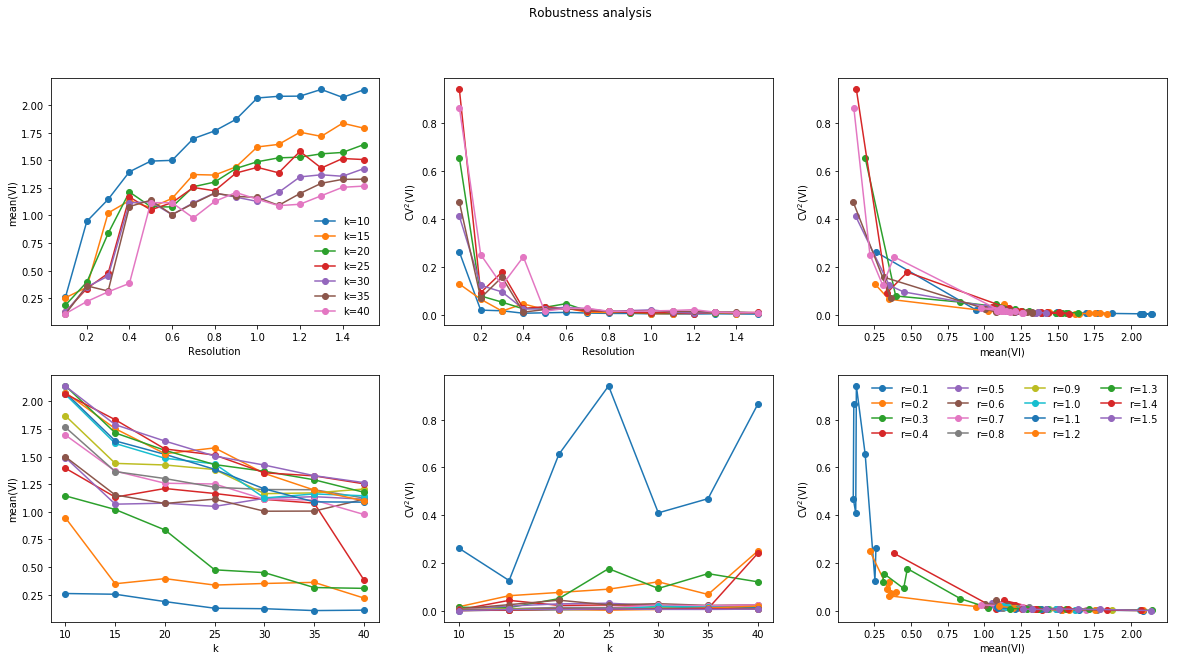

In [28]:
%get VarInfoMatrix.mean --from R
%get VarInfoMatrix.var --from R
%get k.vec --from R
%get res.vec --from R

#VarInfoMatrix_mean=np.loadtxt('VarInfoMatrix_mean.txt')
#VarInfoMatrix_var=np.loadtxt('VarInfoMatrix_mean.txt')
#k_vec=np.loadtxt('k_vec.txt')
#res_vec=np.loadtxt('res_vec.txt')

print(k_vec)
print(res_vec)

fig, axes = plt.subplots(2, 3,figsize=(20,10))
fig.suptitle('Robustness analysis')

axes[0,0].set_xlabel('Resolution')
axes[0,0].set_ylabel('mean(VI)')
for i in range(len(VarInfoMatrix_mean[:,0])):
    axes[0, 0].plot(res_vec,VarInfoMatrix_mean[i,:],'-o',label='k=%d' % k_vec[i])
axes[0,0].legend(loc=0,frameon=False)
axes[0,1].set_xlabel('Resolution')
axes[0,1].set_ylabel(r'CV$^2$(VI)')
for i in range(len(VarInfoMatrix_mean[:,0])):
    axes[0, 1].plot(res_vec,VarInfoMatrix_var[i,:]/VarInfoMatrix_mean[i,:]**2,
                    '-o',label='k=%d' % k_vec[i])
#axes[0,1].legend(loc=0,frameon=False)
axes[0,2].set_xlabel('mean(VI)')
axes[0,2].set_ylabel(r'CV$^2$(VI)')
for i in range(len(VarInfoMatrix_mean[:,0])):
    axes[0,2].plot(VarInfoMatrix_mean[i,:],VarInfoMatrix_var[i,:]/VarInfoMatrix_mean[i,:]**2,
                   '-o',label='k=%d' % k_vec[i])
#axes[0,2].legend(loc=0,frameon=False)

axes[1,0].set_xlabel('k')
axes[1,0].set_ylabel('mean(VI)')
for i in range(len(VarInfoMatrix_mean[0,:])):
    axes[1, 0].plot(k_vec,VarInfoMatrix_mean[:,i],'-o',label='r=%.1f' % res_vec[i])
#axes[1,0].legend(loc=0,frameon=False,ncol=4)
axes[1,1].set_xlabel('k')
axes[1,1].set_ylabel(r'CV$^2$(VI)')
for i in range(len(VarInfoMatrix_mean[0,:])):
    axes[1, 1].plot(k_vec,VarInfoMatrix_var[:,i]/VarInfoMatrix_mean[:,i]**2,'-o',
                    label='r=%.1f' % res_vec[i])
#axes[1,1].legend(loc=0,frameon=False)
axes[1,2].set_xlabel('mean(VI)')
axes[1,2].set_ylabel(r'CV$^2$(VI)')
for i in range(len(VarInfoMatrix_mean[0,:])):
    axes[1,2].plot(VarInfoMatrix_mean[:,i],VarInfoMatrix_var[:,i]/VarInfoMatrix_mean[:,i]**2,
                   '-o',label='r=%.1f' % res_vec[i])
axes[1,2].legend(loc=0,frameon=False,ncol=4)

For the moment we choose resolution=0.5 and nr neighbors (k)=20

# Clustering using Louvain algorithm

In [23]:
xenopus.combined <- RunPCA(xenopus.combined, npcs = 30, verbose = FALSE)
xenopus.combined <- RunUMAP(xenopus.combined, reduction = "pca", dims = 1:20,set.seed=42)
xenopus.combined <- RunTSNE(xenopus.combined, reduction = "pca", dims = 1:20)
xenopus.combined <- FindNeighbors(xenopus.combined, reduction = "pca", dims = 1:20,k.param=20)
xenopus.combined <- FindClusters(xenopus.combined, resolution =0.5)

Warning message:
“The following arguments are not used: set.seed”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:21:47 UMAP embedding parameters a = 0.9922 b = 1.112

14:21:47 Read 3405 rows and found 20 numeric columns

14:21:47 Using Annoy for neighbor search, n_neighbors = 30

14:21:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:21:48 Writing NN index file to temp file /var/folders/s7/jyt31pln5m7gbyc7rxhf0jdw0000gn/T//RtmpySDoDe/file23417cffad2c

14:21:48 Searching Annoy index using 1 thread, search_k = 3000

14:21:48 Ann

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3405
Number of edges: 124306

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8673
Number of communities: 11
Elapsed time: 0 seconds


## Check clusters' composition by batch and condition (IVF/NT)

In [24]:
xenopus.combined

An object of class Seurat 
33179 features across 3405 samples within 2 assays 
Active assay: integrated (2000 features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

In [25]:
table(Idents(xenopus.combined))


  0   1   2   3   4   5   6   7   8   9  10 
748 732 412 347 266 220 177 173 169 134  27 

In [26]:
table(Idents(xenopus.combined), xenopus.combined$stim)

    
     SIGAA2 SIGAB2 SIGAH12 SIGAH5
  0     123    148     242    235
  1     191     88     209    244
  2     102     79     124    107
  3      35     44      60    208
  4      27     24     137     78
  5      24     38      63     95
  6      20     36      63     58
  7       8     16      35    114
  8      25      7      30    107
  9       4     17      86     27
  10      7     17       1      2

In [27]:
table(Idents(xenopus.combined), xenopus.combined$isnt)

    
     IVF  NT
  0  358 390
  1  435 297
  2  209 203
  3  243 104
  4  105 161
  5  119 101
  6   78  99
  7  122  51
  8  132  37
  9   31 103
  10   9  18

## Plot the UMAP

In [61]:
library(repr)
options(repr.plot.width=6, repr.plot.height=5)

xenopus.combined <- readRDS(file = "xenopus_combined_and_clustered_with_10.rds")

pdf(file = "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/DRAFT_PAPER/FIGURES/UMAP_all_clusters.pdf",width=6,height=5)

#plot batches and clusters
# p1 <- DimPlot(xenopus.combined, reduction = "umap", group.by = "stim", dim.1 = 10, dim.2 = 10)
p2 <- DimPlot(xenopus.combined, reduction = "umap", label = TRUE,label.size=6)
p2 + theme(legend.position = "none",text = element_text(size=20),axis.text.x = element_text(size = 20),axis.text.y = element_text(size = 20)) 
dev.off()

pdf 
  2

The following functions and any applicable methods accept the dots: CombinePlots
The following functions and any applicable methods accept the dots: CombinePlots
The following functions and any applicable methods accept the dots: CombinePlots
The following functions and any applicable methods accept the dots: CombinePlots


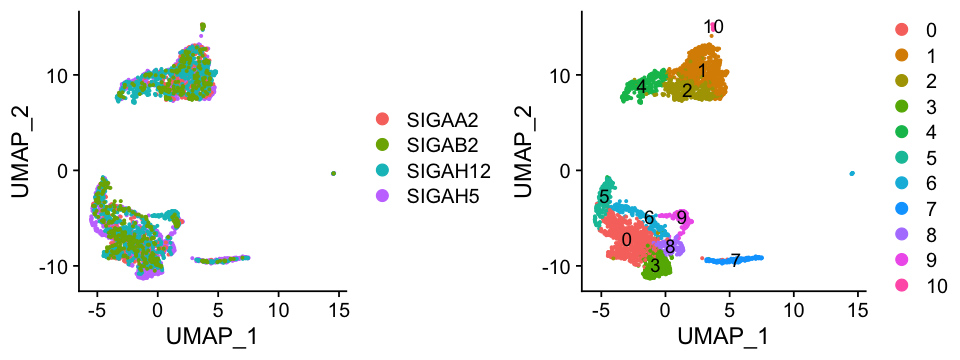

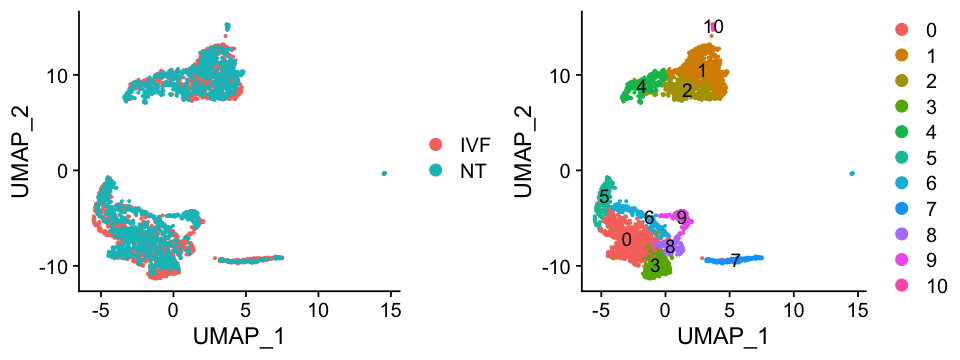

In [102]:
library(repr)
options(repr.plot.width=8, repr.plot.height=3)


#plot batches and clusters
p1 <- DimPlot(xenopus.combined, reduction = "umap", group.by = "stim", dim.1 = 10, dim.2 = 10)
p2 <- DimPlot(xenopus.combined, reduction = "umap", label = TRUE, dim.1 = 10, dim.2 = 10)
plt <- plot_grid(p1, p2,rel_widths = c(1.1, 1))
plt

#plot IVF/NT condition and clusters
p1 <- DimPlot(xenopus.combined, reduction = "umap", group.by = "isnt", dim.1 = 10, dim.2 = 10)
p2 <- DimPlot(xenopus.combined, reduction = "umap", label = TRUE, dim.1 = 10, dim.2 = 10)
plt <- plot_grid(p1, p2,rel_widths = c(1.1, 1))
plt

## Quality features of cluster 10

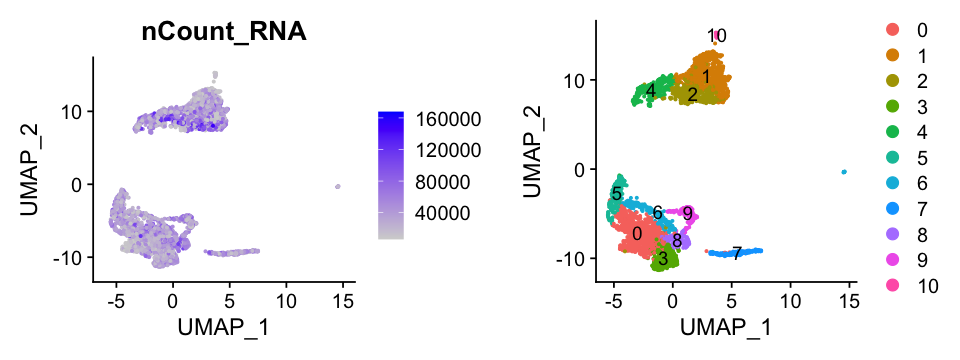

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



pdf 
  2

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



pdf 
  2

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



pdf 
  2

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



pdf 
  2

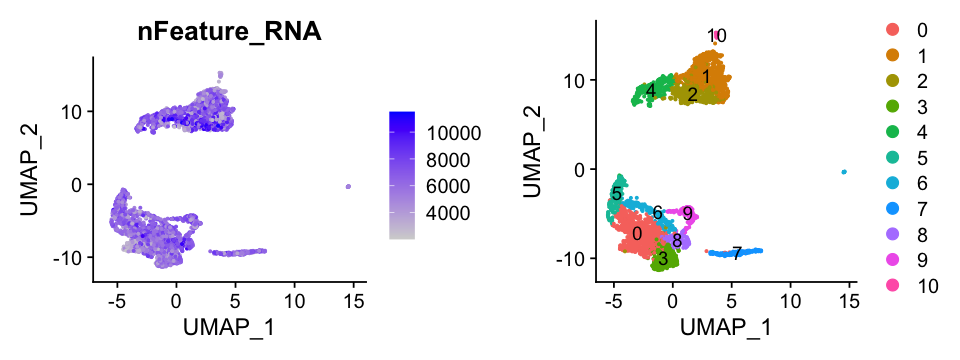

In [60]:
library(repr)
options(repr.plot.width=8, repr.plot.height=3)
#plot batches and clusters

p1 <- FeaturePlot(xenopus.combined, features = 'nCount_RNA' )
p2 <- DimPlot(xenopus.combined, reduction = "umap", label = TRUE)
plt <- plot_grid(p1, p2,rel_widths = c(1.1, 1))
plt

p1 <- FeaturePlot(xenopus.combined, features = 'nFeature_RNA' )
p2 <- DimPlot(xenopus.combined, reduction = "umap", label = TRUE)
plt <- plot_grid(p1, p2,rel_widths = c(1.1, 1))
plt

pdf(file = "./PLOTS/Vln_UMI.pdf",width=8,height=3)
p3<- VlnPlot(xenopus.combined, features = 'nCount_RNA',pt.size = 0.5)
p3+theme(legend.position = "none")+labs(title="",
        x ="Clusters", y = "UMIs per cell") + scale_y_continuous(labels = function(x) format(x, scientific = TRUE))
dev.off()
pdf(file = "./PLOTS/Vln_UMI_cond.pdf",width=8.5,height=3)
p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p4+labs(title="",
        x ="Clusters", y = "UMIs per cell")+ scale_y_continuous(labels = function(x) format(x, scientific = TRUE))
dev.off()

pdf(file = "./PLOTS/Vln_genes.pdf",width=8,height=3)
p3<- VlnPlot(xenopus.combined, features = 'nFeature_RNA',pt.size = 0.5)
p3+theme(legend.position = "none")+labs(title="",
        x ="Clusters", y = "Genes per cell")+ scale_y_continuous(labels = function(x) format(x, scientific = TRUE))
dev.off()

pdf(file = "./PLOTS/Vln_genes_cond.pdf",width=8.5,height=3)
p4<- VlnPlot(xenopus.combined, features = 'nFeature_RNA',split.by = "isnt",pt.size = 0.5)
p4+labs(title="",
        x ="Clusters", y = "Genes per cell")+ scale_y_continuous(labels = function(x) format(x, scientific = TRUE))
dev.off()

In [5]:
# Eliminate cluster 10 and save the object
xenopus.combined.new <- subset(xenopus.combined, idents=c(0,1,2,3,4,5,6,7,8,9))

# Save the object
saveRDS(xenopus.combined.new, file = "xenopus_combined_and_clustered.rds")

## Create Seurat object with the combined raw data and save them

In [6]:
library(Seurat)
library(ggplot2)
library(cowplot)

SIGAH12.data<-read.table(file=paste0("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/10XCountMatrix/","SIGAH12_91_Chm3_FC2.csv"),
                         row.names = 1,header=TRUE,sep=",")
rownames(SIGAH12.data) <- convertGeneList(rownames(SIGAH12.data))
SIGAH12 <- CreateSeuratObject(counts = SIGAH12.data, project = "SIGAH12")
SIGAH12$stim <- "SIGAH12"
SIGAH12$isnt <- "NT"
SIGAH12$exp <- "Exp2"

SIGAH5.data<-read.table(file=paste0("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/10XCountMatrix/","SIGAH5_91_Chm3_FC2.csv"),
                        row.names = 1,header=TRUE,sep=",")
rownames(SIGAH5.data) <- convertGeneList(rownames(SIGAH5.data))
#SIGAH5.data <- Read10X(data.dir = "/Users/christopherpenfold/Desktop/10X/Eva_10X/SIGAH5_91_Chm3_FC2/outs/filtered_feature_bc_matrix")
SIGAH5 <- CreateSeuratObject(counts = SIGAH5.data, project = "SIGAH5")
SIGAH5$stim <- "SIGAH5"
SIGAH5$isnt <- "IVF"
SIGAH5$exp <- "Exp2"

SIGAA2.data<-read.table(file=paste0("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/10XCountMatrix/","SIGAA2_91_Chm3_FC2r.csv"),
                        row.names = 1,header=TRUE,sep=",")
rownames(SIGAA2.data) <- convertGeneList(rownames(SIGAA2.data))
#SIGAA2.data <- Read10X(data.dir = "/Users/christopherpenfold/Desktop/Eva/10X/SIGAA2_91_Chm3_FC2r/outs/filtered_feature_bc_matrix")
SIGAA2 <- CreateSeuratObject(counts = SIGAA2.data, project = "SIGAA2")
SIGAA2$stim <- "SIGAA2"
SIGAA2$isnt <- "IVF"
SIGAA2$exp <- "Exp1"

SIGAB2.data<-read.table(file=paste0("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/10XCountMatrix/","SIGAB2_91_Chm3_FC2r.csv"),
                        row.names = 1,header=TRUE,sep=",")
rownames(SIGAB2.data) <- convertGeneList(rownames(SIGAB2.data))
#SIGAB2.data <- Read10X(data.dir = "/Users/christopherpenfold/Desktop/Eva/10X/SIGAB2_91_Chm3_FC2r/outs/filtered_feature_bc_matrix")
SIGAB2 <- CreateSeuratObject(counts = SIGAB2.data, project = "SIGAB2")
SIGAB2$stim <- "SIGAB2"
SIGAB2$isnt <- "NT"
SIGAB2$exp <- "Exp1"

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [14]:
# Save the combined raw data (we will use them for DE analysis with DESeq2)
#Merge the raw counts for the 4 batches
xenopus.combined.raw <- merge(SIGAH5, y = c(SIGAA2, SIGAH12, SIGAB2))

#Load the batch integrated data
xenopus.combined <- readRDS(file = "xenopus_combined_and_clustered_with_10.rds")

#Check that the cell order is the same
all(colnames(xenopus.combined.raw)==colnames(xenopus.combined))

#Assign cluster identities to the raw data
xenopus.combined.raw$seurat_clusters <- xenopus.combined$seurat_clusters

Idents(xenopus.combined.raw) <- xenopus.combined.raw$seurat_clusters

xenopus.combined.raw.new <- subset(xenopus.combined.raw, idents=c(0,1,2,3,4,5,6,7,8,9))

saveRDS(xenopus.combined.raw.new, file = "xenopus_combined_and_clustered_raw.rds")

[1] TRUE

In [17]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] repr_1.1.0    cowplot_1.1.0 ggplot2_3.3.2 Seurat_3.1.4 

loaded via a namespace (and not attached):
  [1] tsne_0.1-3          nlme_3.1-145        bitops_1.0-6       
  [4] RcppAnnoy_0.0.17    RColorBrewer_1.1-2  httr_1.4.2         
  [7] numDeriv_2016.8-1.1 sctransform_0.2.1   tools_3.5.2        
 [10] R6_2.5.0            irlba_2.3.3         KernSmooth_2.23-16 
 [13] uwot_0.1.9          lazyeval_0.2.2      BiocGenerics_0.28.0
 [16] colorspace_2.0-0    sn_1.6-2            withr_2.3.0        
 [19] gridExtra_2.3       tidyselect_1.1.0  